In [2]:
!wget http://www.heatmapping.org/tutorial/tutorial.zip

--2020-04-10 20:15:10--  http://www.heatmapping.org/tutorial/tutorial.zip
Resolving www.heatmapping.org (www.heatmapping.org)... 84.200.223.19
Connecting to www.heatmapping.org (www.heatmapping.org)|84.200.223.19|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524130 (512K) [application/zip]
Saving to: ‘tutorial.zip’

tutorial.zip        100%[===================>] 511.85K   250KB/s    in 2.0s    

2020-04-10 20:15:13 (250 KB/s) - ‘tutorial.zip’ saved [524130/524130]



In [3]:
!unzip tutorial.zip

Archive:  tutorial.zip
   creating: data/
  inflating: data/T.txt              
  inflating: data/X.txt              
   creating: params/
  inflating: params/l1-B.txt         
  inflating: params/l2-W.txt         
  inflating: params/l1-W.txt         
  inflating: params/l3-B.txt         
  inflating: params/l3-W.txt         
  inflating: params/l2-B.txt         
  inflating: castle.jpg              
  inflating: utils.py                


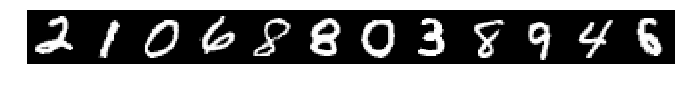

In [4]:
import utils
X,T = utils.loaddata()
%matplotlib inline
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

(12, 784)
(12,)


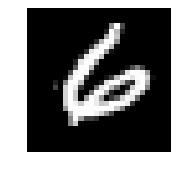

6.0


In [13]:
print(X.shape)
print(T.shape)
utils.digit(X[3].reshape(28,28),2,2)
print(T[3])

In [16]:
W,B = utils.loadparams()
L = len(W)
print(L)

3


In [10]:
import numpy
A = [X]+[None]*L
for l in range(L):
    A[l+1] = numpy.maximum(0,A[l].dot(W[l])+B[l])

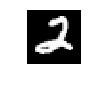

[0] 0.0  [1] 3.6  [2] 49.1  [3] 8.9  [4] 0.0  [5] 0.0  [6] 0.0  [7] 1.4  [8] 1.6  [9] 0.0


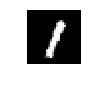

[0] 0.0  [1] 27.0  [2] 0.0  [3] 0.0  [4] 5.3  [5] 0.0  [6] 0.0  [7] 13.0  [8] 8.1  [9] 2.3


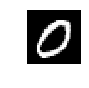

[0] 49.1  [1] 0.0  [2] 10.6  [3] 0.0  [4] 0.0  [5] 0.2  [6] 0.0  [7] 3.0  [8] 0.0  [9] 9.2


In [11]:
for i in range(3):
    utils.digit(X[i].reshape(28,28),0.75,0.75)
    p = A[L][i]
    print("  ".join(['[%1d] %.1f'%(d,p[d]) for d in range(10)]))

### Convert output as (n,10) matrix, each row having activation of target class

In [43]:
R = [None]*L + [A[L]*(T[:,None]==numpy.arange(10))]
2*([1] == numpy.arange(10))    # Checking how above line works

array([0, 2, 0, 0, 0, 0, 0, 0, 0, 0])

# Relevance propagation

In [27]:
def rho(w,l):  return w + [None,0.1,0.0,0.0][l] * numpy.maximum(0,w)
def incr(z,l): return z + [None,0.0,0.1,0.0][l] * (z**2).mean()**.5+1e-9

In [44]:
for l in range(1,L)[::-1]:
    print("In layer "+str(l))
    w = rho(W[l],l)
    b = rho(B[l],l)
    
    #Printing top left corner of W matrix before and after transformation
    
    print(W[l][:3,:3])
    print(w[:3,:3])
    print(B[l][:3],b[:3])
    
    z = incr(A[l].dot(w)+b,l)    # step 1
    s = R[l+1] / z               # step 2
    c = s.dot(w.T)               # step 3
    R[l] = A[l]*c                # step 4

In layer 2
[[-0.366 -0.336 -0.696]
 [-0.049  0.163 -0.082]
 [ 0.295 -0.396  0.189]]
[[-0.366 -0.336 -0.696]
 [-0.049  0.163 -0.082]
 [ 0.295 -0.396  0.189]]
[-0.161 -0.47  -0.323] [-0.161 -0.47  -0.323]
In layer 1
[[-0.04  -0.06   0.075]
 [-0.001  0.008  0.092]
 [ 0.028 -0.064 -0.04 ]]
[[-0.04   -0.06    0.0825]
 [-0.001   0.0088  0.1012]
 [ 0.0308 -0.064  -0.04  ]]
[ 0.094  0.003 -0.153] [ 0.1034  0.0033 -0.153 ]


## Different code for first layer

In [46]:

w  = W[0]
wp = numpy.maximum(0,w)
wm = numpy.minimum(0,w)
lb = A[0]*0-1
hb = A[0]*0+1

z = A[0].dot(w)-lb.dot(wp)-hb.dot(wm)+1e-9        # step 1
s = R[1]/z                                        # step 2
c,cp,cm  = s.dot(w.T),s.dot(wp.T),s.dot(wm.T)     # step 3
R[0] = A[0]*c-lb*cp-hb*cm                         # step 4

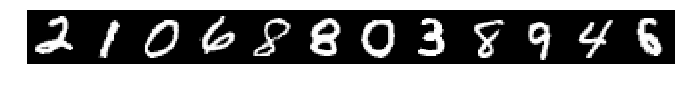

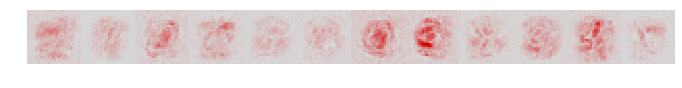

In [47]:
utils.digit(X.reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)
utils.heatmap(R[0].reshape(1,12,28,28).transpose(0,2,1,3).reshape(28,12*28),9,0.75)

# LRP in VGGnet 

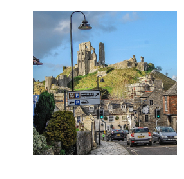

In [54]:
import cv2
img = numpy.array(cv2.imread('castle.jpg'))
#utils.image(img,2,2)
img = img[...,::-1]/255.0
utils.image(img,2,2)

In [59]:
import torch

mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

z = img[numpy.newaxis]
y = z.transpose([0,3,1,2])

print(mean.shape)
print(z.shape)
print(y.shape)

X = (torch.FloatTensor(y*1) - mean) / std

torch.Size([1, 3, 1, 1])
(1, 224, 224, 3)
(1, 3, 224, 224)


In [64]:
import torchvision

model = torchvision.models.vgg16(pretrained=True)
model.eval()
for it in model._modules:
    print(it)
    print(model._modules[it])
    print("___")
layers = list(model._modules['features']) + utils.toconv(list(model._modules['classifier']))
L = len(layers)

features
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, 

In [65]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [66]:
scores = numpy.array(A[-1].data.view(-1))
ind = numpy.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(utils.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.108
         street sign (919):  7.102
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


In [67]:
T = torch.FloatTensor((1.0*(numpy.arange(1000)==483).reshape([1,1000,1,1])))

R = [None]*L + [(A[-1]*T).data]

In [68]:
for l in range(1,L)[::-1]:
    
    A[l] = (A[l].data).requires_grad_(True)

    if isinstance(layers[l],torch.nn.MaxPool2d): layers[l] = torch.nn.AvgPool2d(2)

    if isinstance(layers[l],torch.nn.Conv2d) or isinstance(layers[l],torch.nn.AvgPool2d):

        if l <= 16:       rho = lambda p: p + 0.25*p.clamp(min=0); incr = lambda z: z+1e-9
        if 17 <= l <= 30: rho = lambda p: p;                       incr = lambda z: z+1e-9+0.25*((z**2).mean()**.5).data
        if l >= 31:       rho = lambda p: p;                       incr = lambda z: z+1e-9

        z = incr(utils.newlayer(layers[l],rho).forward(A[l]))  # step 1
        s = (R[l+1]/z).data                                    # step 2
        (z*s).sum().backward(); c = A[l].grad                  # step 3
        R[l] = (A[l]*c).data                                   # step 4
        
    else:
        
        R[l] = R[l+1]

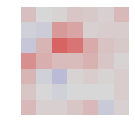

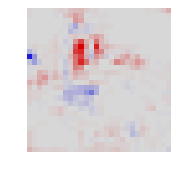

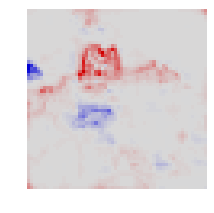

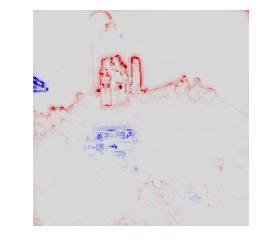

In [69]:
for i,l in enumerate([31,21,11,1]):
    utils.heatmap(numpy.array(R[l][0]).sum(axis=0),0.5*i+1.5,0.5*i+1.5)

In [70]:
A[0] = (A[0].data).requires_grad_(True)

lb = (A[0].data*0+(0-mean)/std).requires_grad_(True)
hb = (A[0].data*0+(1-mean)/std).requires_grad_(True)

z = layers[0].forward(A[0]) + 1e-9                                     # step 1 (a)
z -= utils.newlayer(layers[0],lambda p: p.clamp(min=0)).forward(lb)    # step 1 (b)
z -= utils.newlayer(layers[0],lambda p: p.clamp(max=0)).forward(hb)    # step 1 (c)
s = (R[1]/z).data                                                      # step 2
(z*s).sum().backward(); c,cp,cm = A[0].grad,lb.grad,hb.grad            # step 3
R[0] = (A[0]*c+lb*cp+hb*cm).data                                       # step 4


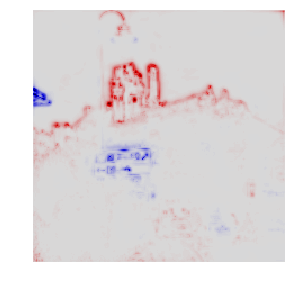

In [71]:
utils.heatmap(numpy.array(R[0][0]).sum(axis=0),3.5,3.5)

## Original tutorial can be found <a href="http://www.heatmapping.org/tutorial/">here</a>